# Simple 1D mixture without nuissance parameters

In [55]:
%matplotlib inline
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
# easier access to tensorflow distributions
ds = tf.contrib.distributions
layers = tf.keras.layers

sess = tf.Session()

## unbinned likelihood

In [420]:
# use (None,) shape so a vector of g can be used
g = tf.placeholder_with_default([0.05], shape=(None,))
# to simplify broadcasting in case of multiple g input
def repeat_g(x):
    return tf.tile(x, tf.shape(g))

components = [
    ds.Normal(loc=repeat_g([-2.0]), scale=repeat_g([0.75])), # c0 (background)
    ds.Normal(loc=repeat_g([0.0]), scale=repeat_g([2.0])), # c1 (background)
    ds.Normal(loc=repeat_g([1.0]), scale=repeat_g([0.5]))  # c2 (bump/signal)
]

probs_no_c2 = tf.convert_to_tensor([0.5,0.5,0.])
g_T = g[:,tf.newaxis]
probs = tf.concat([probs_no_c2[0:2]-g_T/2.,probs_no_c2[2:3]+g_T],axis=1)
cat = ds.Categorical(probs=probs)
# mix is the mixture distribution (g can be modified)
mix = ds.Mixture(components=components, cat=cat)

In [421]:
# get some toy data
random_seed = 47
data = mix.sample((5000), seed = random_seed)
data_arr = sess.run(data, feed_dict={g : [0.05]})
data = tf.convert_to_tensor(data_arr)

data_arr

array([[-0.7578105],
       [ 0.8631449],
       [ 2.7167003],
       ...,
       [ 0.9275848],
       [-1.8137566],
       [-2.4737775]], dtype=float32)

In [422]:
x_values = tf.linspace(-5.,5.,num=1000)[:,tf.newaxis]
x_values_arr, probs_arr = sess.run([x_values, mix.prob(x_values)],
                                   feed_dict={g : [0.00, 0.05]})

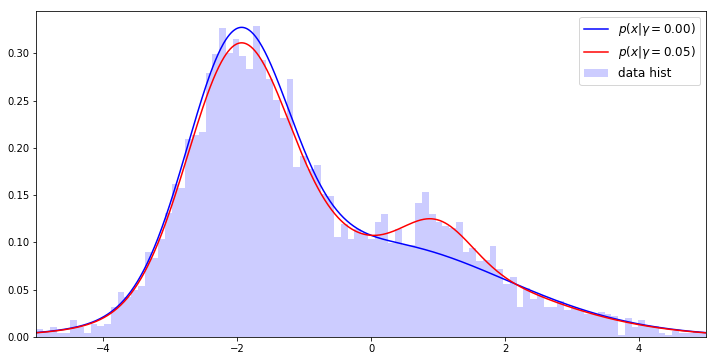

In [423]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(x_values_arr, probs_arr[:,0], label=r"$p(x|\gamma=0.00)$", color="b")
ax.plot(x_values_arr, probs_arr[:,1], label=r"$p(x|\gamma=0.05)$", color="r")
bins =  np.linspace(-5.,5.,100,endpoint=True, dtype=np.float32)
ax.hist(data_arr, bins=bins, normed=True, label="data hist",
        alpha=0.2, color="b")
ax.set_xlim(-5.,5.)
ax.legend(loc="best", prop={'size' : 12})

fig;

In [424]:
g_arr = np.linspace(0.03,0.07,100, endpoint=True)
nll = - tf.reduce_sum(mix.log_prob(data),axis=0)
nll_arr = sess.run(nll,feed_dict={g : g_arr})

In [425]:
# gradient of sum is sum of grads in this case
nll_grads = tf.gradients(tf.reduce_sum(nll), g)
nll_grads_arr = sess.run(nll_grads,feed_dict={g : g_arr})[0]

In [426]:
# hessian of sum is sum of hess in this case
# could we made faster with a bit of care
nll_hesss = tf.hessians(tf.reduce_sum(nll), g)
nll_hesss_arr = sess.run(nll_hesss,feed_dict={g : g_arr})[0]
cov_arr = 1./np.diagonal(nll_hesss_arr)

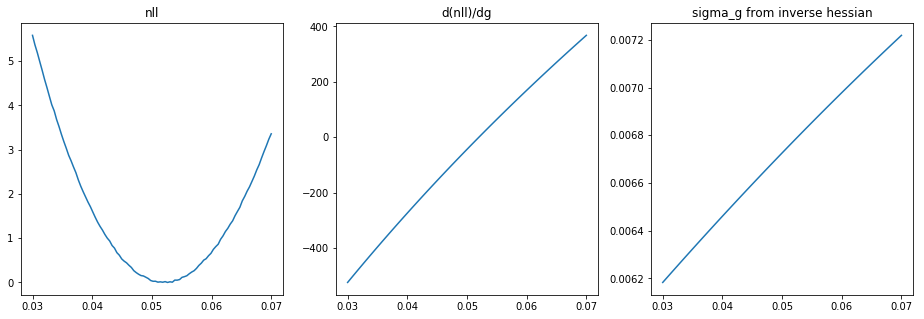

In [256]:
fig, axs = plt.subplots(1,3,figsize = (16,5))

axs[0].plot(g_arr, nll_arr-nll_arr.min());
axs[0].set_title("nll")
axs[1].plot(g_arr, nll_grads_arr);
axs[1].set_title("d(nll)/dg")
axs[2].plot(g_arr, np.sqrt(cov_arr));
axs[2].set_title("sigma_g from inverse hessian")

fig;

# binned likelihood

In [262]:
# generate high stat samples
random_seed = 12
n_samples = 100000
c_samples = [c.sample(n_samples, seed = random_seed) for c in components] 
c_samples_arr =  sess.run(c_samples)

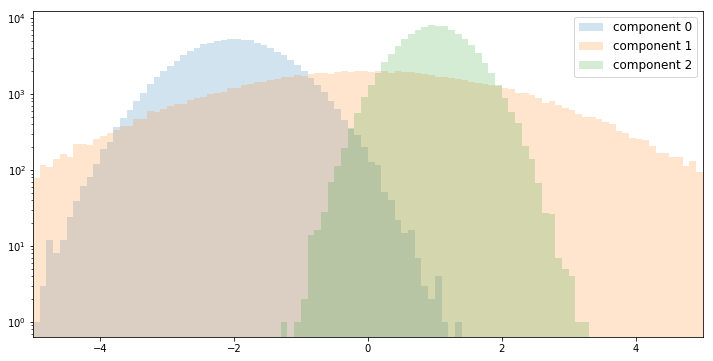

In [329]:
fig, ax = plt.subplots(figsize=(12,6))
bins = np.linspace(-5.,5.,101,endpoint=True, dtype=np.float32)
c_samples_h_arr = []
for c_i, c_sample_arr in enumerate(c_samples_arr):
    c_samples_h_arr.append(ax.hist(c_sample_arr,bins,alpha=0.2,
                           label="component {}".format(c_i))[0])
data_h_arr = np.histogram(data_arr, bins=bins)[0]
ax.set_yscale("log")
ax.set_xlim(-5.,5.)
ax.legend(loc="best", prop={'size' : 12})
fig;

In [308]:
# normalize histogram arrays
c_samples_hn_arr = [arr/arr.sum() for arr in c_samples_h_arr]
# convert to tensorflow constants
c_samples_hn =  [tf.convert_to_tensor(arr, dtype=tf.float32) for arr in c_samples_hn_arr]

In [321]:
# use (None,) shape so a vector of g can be used
g_prime = tf.placeholder_with_default([0.05], shape=(None,))
g_prime_T = g_prime[:,tf.newaxis]
n_data = tf.placeholder_with_default([5000.], shape=(None,))
# get expected counts, could use logs to reduce num. unc.
exp_counts = n_data*(c_samples_hn[0]*(0.5-g_prime_T/2.)
                     +c_samples_hn[1]*(0.5-g_prime_T/2.)
                     +c_samples_hn[2]*g_prime_T)

In [331]:
# build distribution
b_mix = ds.Poisson(exp_counts)

In [387]:
# sample some toys for g=0.00 and g=0.05 
random_seed = 90
n_toys = 10
toy_samples = b_mix.sample((n_toys), seed= random_seed)
toy_samples_arr = sess.run(toy_samples, feed_dict={g_prime : [0.00,0.05]})

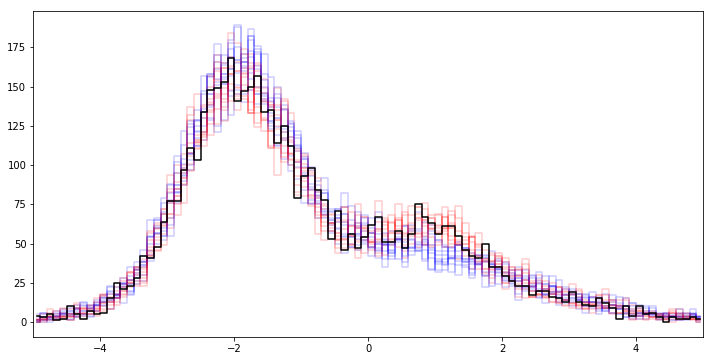

In [404]:
fig, ax = plt.subplots(figsize=(12,6))

bin_centers = 0.5*(bins[1:]+bins[:-1])
for t_i in range(n_toys):
    ax.errorbar(bin_centers,toy_samples_arr[t_i,0,:],
                marker="", drawstyle="steps-mid",
                color="b",alpha=0.2)
    ax.errorbar(bin_centers,toy_samples_arr[t_i,1,:],
                marker="", drawstyle="steps-mid",
                color="r",alpha=0.2)
ax.errorbar(bin_centers, data_h_arr,
            marker="",color="k", drawstyle="steps-mid")
ax.set_xlim(-5,5.)

fig;

In [403]:
data_h = tf.convert_to_tensor(data_h_arr, dtype=tf.float32)
g_prime_arr = np.linspace(0.03,0.07,100, endpoint=True)
b_nll = - tf.reduce_sum(b_mix.log_prob(data_h),axis=-1)
b_nll_arr = sess.run(b_nll,feed_dict={g_prime : g_prime_arr})

In [406]:
# gradient of sum is sum of grads in this case
b_nll_grads = tf.gradients(tf.reduce_sum(b_nll), g_prime)
b_nll_grads_arr = sess.run(b_nll_grads,feed_dict={g_prime : g_prime_arr})[0]

In [411]:
# hessian of sum is sum of hess in this case
# could we made faster with a bit of care
b_nll_hesss = tf.hessians(tf.reduce_sum(b_nll), g_prime)
b_nll_hesss_arr = sess.run(b_nll_hesss,feed_dict={g_prime : g_prime_arr})[0]
b_cov_arr = 1./np.diagonal(b_nll_hesss_arr)

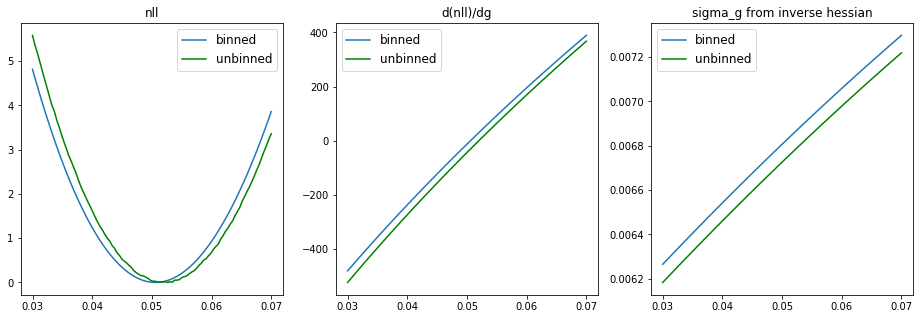

In [432]:
fig, axs = plt.subplots(1,3,figsize = (16,5))

axs[0].plot(g_prime_arr, b_nll_arr-b_nll_arr.min(),
            label="binned")
axs[0].plot(g_arr, nll_arr-nll_arr.min(),
            color="g", label="unbinned")
axs[0].set_title("nll")
axs[0].legend(loc="best", prop={'size' : 12})
axs[1].plot(g_prime_arr, b_nll_grads_arr,
            label="binned")
axs[1].plot(g_arr, nll_grads_arr,
            color="g", label="unbinned")
axs[1].set_title("d(nll)/dg")
axs[1].legend(loc="best", prop={'size' : 12})
axs[2].plot(g_prime_arr, np.sqrt(b_cov_arr),
            label="binned")
axs[2].plot(g_arr, np.sqrt(cov_arr),
            color="g",label="unbinned")
axs[2].set_title("sigma_g from inverse hessian")
axs[2].legend(loc="best", prop={'size' : 12})

fig;